In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Figures from the paper
island_fig = cv.imread('images/fig5.png')
butterfly_fig = cv.imread('images/fig7.png')
dolphin_fig = cv.imread('images/fig8.png')
bench_fig = cv.imread('images/fig8-2008.png')
car_fig = cv.imread('images/fig9-2008.png')

In [3]:
#Convert an image back to RGB and display it
def display_image(image):
    plt.figure(dpi = 100)
    plt.axis('off')
    plt.imshow(cv.cvtColor(image,cv.COLOR_BGR2RGB))

In [4]:
def get_sobel(image):
    
    #https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html
    
    #image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    scale = 1
    delta = 0
    ddepth = cv.CV_64F #What is this?

    #Add gradient to image first??
    #Remove noise by blurring with a Gaussian filter ( kernel size = 3 )
    #display_image(image)
    #image = cv.GaussianBlur(image, (3, 3), 0, 0, cv.BORDER_DEFAULT);
    #display_image(image)
    
    sobel_dx = cv.Sobel(image, ddepth, 1, 0, ksize=1, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    sobel_dy = cv.Sobel(image, ddepth, 0, 1, ksize=1, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    abs_sobel_dx = cv.convertScaleAbs(sobel_dx)
    abs_sobel_dy = cv.convertScaleAbs(sobel_dy)

    #sobel_out = cv.addWeighted(abs_sobel_dx, 0.5, abs_sobel_dy, 0.5, 0)
    sobel_out = abs_sobel_dx + abs_sobel_dy
    
    return sobel_out

In [5]:
def get_scharr(image):
    
    #https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gaa13106761eedf14798f37aa2d60404c9
    
    #image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    scale = -1
    delta = 0
    ddepth = cv.CV_16S #What is this?

    #Add gradient to image first??
    #Remove noise by blurring with a Gaussian filter ( kernel size = 3 )
    #GaussianBlur(image, src, Size(3, 3), 0, 0, BORDER_DEFAULT);

    scharr_dx = cv.Scharr(image, ddepth, 1, 0, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    scharr_dy = cv.Scharr(image, ddepth, 0, 1, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    abs_scharr_dx = cv.convertScaleAbs(scharr_dx)
    abs_scharr_dy = cv.convertScaleAbs(scharr_dy)
    
    #abs_scharr_dx = np.abs(scharr_dx)
    #abs_scharr_dy = np.abs(scharr_dy)

    #scharr_out = cv.addWeighted(abs_scharr_dx, 0.5, abs_scharr_dy, 0.5, 0)
    scharr_out = abs_scharr_dx + abs_scharr_dy
    
    return scharr_out

In [6]:
def calculate_min_energy(image_dydx):
    rows = len(image_dydx)
    cols = len(image_dydx[0])
    
    #print("calculate_min_energy()...")
    #print("\trows= ",rows)
    #print("\tcols= ",cols)
    
    for i in range(1,rows): #skip first row
        
        #print("\t\tStarting row: ",i)
            
        for j in range(cols):
            
            min_energy[i][j] = get_pixel_min_energy(image_dydx,rows,cols,i,j)
            
    #print(min_energy[0])
    #print(min_energy[rows-1])
            

In [7]:
def get_pixel_min_energy(image_dydx,rows,cols,i,j):
    
    pixel_energy = image_dydx[i][j]
    neighbors = []
    
    #Recursively get cumulative min energy for north, northeast, northwest neighbors
    if(i-1 >= 0):
        
        #If this energy has not already been calculated, calculate it
        if(min_energy[i-1][j] < 0):
            n_neighbor = get_pixel_min_energy(image_dydx,rows,cols,i-1,j)
            
        #Else, just look it up
        else:
            n_neighbor = min_energy[i-1][j]
            
        neighbors.append(n_neighbor)
        
        if(j+1 < cols):
            
            #If this energy has not already been calculated, calculate it
            if(min_energy[i-1][j+1] < 0):
                ne_neighbor = get_pixel_min_energy(image_dydx,rows,cols,i-1,j+1)

            #Else, just look it up
            else:
                ne_neighbor = min_energy[i-1][j+1]
            
            neighbors.append(ne_neighbor)
            
        if(j-1 >=0):
            
            #If this energy has not already been calculated, calculate it
            if(min_energy[i-1][j-1] < 0):
                nw_neighbor = get_pixel_min_energy(image_dydx,rows,cols,i-1,j-1)

            #Else, just look it up
            else:
                nw_neighbor = min_energy[i-1][j-1]
            
            neighbors.append(nw_neighbor)

    #Get minimum neighbor
    min_neighbor = 0
    
    #print("\t\t\tneighbors= ",neighbors)

    for k in range(len(neighbors)):

        if(k == 0):
            min_neighbor = neighbors[0] #Set first neighbor because all neighbors > 0

        if(neighbors[k] < min_neighbor):
            min_neighbor = neighbors[k]

    min_cumulative_energy = pixel_energy + min_neighbor
    
    #print("\t\t\tmin_cumulative_energy= ",min_cumulative_energy)
    min_energy[i][j] = min_cumulative_energy

    return min_cumulative_energy
    

In [8]:
#Backtracks the seam from the given row and column building a list of indices
def backtrack_seam(seam_path,row,col,max_col):
    
    if(row > 0):
        direction = 0
        min_neighbor = min_energy[row-1][col] #North        
        
        if(col>0):
            nw_neighbor = min_energy[row-1][col-1]
            if(nw_neighbor < min_neighbor):
                min_neighbor = nw_neighbor
                direction = -1
        
        if(col<max_col):
            ne_neighbor = min_energy[row-1][col+1]
            if(ne_neighbor < min_neighbor):
                min_neighbor = ne_neighbor
                direction = 1
        
        seam_path.append(seam_path[-1] + direction)
        
        backtrack_seam(seam_path,row-1,col+direction,max_col)
        
    return seam_path

In [9]:
#Draws the seam starting from (last row,start column) and following the seam path upwards
#Assumes color image with 3 channels in BGR format as input
last_seam_color = [0,0,255]

def draw_seam(image, seam_path):
    
    rows = len(image)
    i = rows-1
        
    for k in range(0,rows):
        
        j = seam_path[k] #Add the direction to the column index
        image[i][j] = last_seam_color #Color pixel red
        i -= 1 #Move up a row
        
    #Attempt to colorize to see what is happening
    last_seam_color[2] -= 2
    last_seam_color[1] += 2
        
    return image
    

In [10]:
#Removes a vertical seam from the image and returns an image with one less column
def remove_seam_pixels(image, seam_path):
    
    #print(image)
    #display_image(image)
    
    rows = len(image)
    cols = len(image[0])
    i = rows-1    
    cut_image = []
    
    for m in range(rows):
        
        col_to_cut = seam_path[-1*(m+1)]
        cols_to_add = []
        
        for n in range(cols):
            
            if(n != col_to_cut):
                 cols_to_add.append(image[m][n])                
                    
        cut_image.append(cols_to_add)
        
    cut_image = np.array(cut_image)
        
    #print(cut_image)
    #display_image(cut_image)
    return cut_image

In [11]:
#This will store the cumulative minimum energy matrix
min_energy = []

#This will store which pixels have been allocated to seams already
reserved_pixels = []

#Get the seam paths for each column in order from most optimal -> least optimal
ordered_seam_paths = []

In [12]:
#Takes an image and returns an ordered list of columns and their seam paths
def carve_seam(image):
    
    global min_energy
    
    #Convert image to grey scale 
    grey_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #grey_image = image
    #display_image(grey_image)
    
    rows = len(grey_image)
    cols = len(grey_image[0])
    
    #Get sobel image with dy dx of image
    sobel_image = get_sobel(image)
    #sobel_image = get_sobel(image)
    sobel_image = cv.cvtColor(sobel_image, cv.COLOR_BGR2GRAY)
    #display_image(sobel_image)
    #cv.imwrite("sobel_image.png",sobel_image)
    
    #Get scharr image with dy dx of image
    #scharr_image = get_scharr(grey_image)
    #display_image(scharr_image)
    #cv.imwrite("scharr_image.png",scharr_image)
    
    #Initialize a matrix with -1's to store cumulative minimum energies
    min_energy = np.empty_like(grey_image,np.float64)-1
    reserved_pixels = np.empty_like(grey_image,np.float64)
    
    #Calculate the cumulative minimum energy of each pixel 
    calculate_min_energy(sobel_image)
    
    #Get the sorted order of column indices (index of lowest column val -> index of highest)
    seam_order = np.argsort(min_energy[-1])
    #print(seam_order)
    
    #Get seam path for the min column by backtracking cumulative min. energies
    best_seam_path = backtrack_seam([seam_order[0]],rows-1,seam_order[0],cols-1)
    #print(best_seam_path)
    ordered_seam_paths.append(best_seam_path)
    
    #Remove the pixels of the best seam
    image = remove_seam_pixels(image, best_seam_path)
    #cv.imwrite("test_cut.png",image)
    
    return image

In [13]:
#Carve all the seams of an image and store their paths
def carve_seams(image):
    
    print("Seams carved: ", end ='')
          
    for i in range(100):
        image = carve_seam(image)
        print(i,end='')
        
    #print(ordered_seam_paths)
    display_image(image)
    

In [14]:
def draw_seams(image):
    
    seam_count = len(ordered_seam_paths)
    
    for i in range(seam_count):
        image = draw_seam(image,ordered_seam_paths[i])
    
    display_image(image)
    return image
        

In [15]:
#Inserts a vertical seam from the image and returns an image with one more column
def insert_seam(image, seam_path):
    
    #print(image)
    #display_image(image)
    
    rows = len(image)
    cols = len(image[0])
    i = rows-1    
    insert_image = []
    
    for m in range(rows):
        
        col_to_duplicate = seam_path[-1*(m+1)]
        cols_to_add = []
        
        for n in range(cols):
            
            if(n != col_to_duplicate):
                 cols_to_add.append(image[m][n])
            else:
                
                if(n-1 >= 0):
                    left_mean = np.mean([image[m][n], image[m][n-1]],axis=0,dtype=np.uint16)
                    cols_to_add.append(left_mean) #Take mean of seam and left neighbor if present
                else:
                    cols_to_add.append(image[m][n])
                    
                    
                if(n+1 < cols):
                    right_mean = np.mean([image[m][n], image[m][n+1]],axis=0,dtype=np.uint16)
                    cols_to_add.append(right_mean) #Take mean of seam and right neighbor if present
                else:
                    cols_to_add.append(image[m][n])          
                    
                
        insert_image.append(cols_to_add)
        
    insert_image = np.array(insert_image)
        
    return insert_image

In [16]:
#Takes an image and removes 'seams_to_remove' seams from the image
def remove_seams(image, seams_to_remove):
    
    carve_seams(image)
    
    for i in range(seams_to_remove):
        image = remove_seam_pixels(image, ordered_seam_paths[i])
        
    return image
        

In [17]:
#Takes an image and adds 'seams_to_add' seams to the image
def add_seams(image, seams_to_add):
    
    carve_seams(image)
    
    for i in range(seams_to_add):
        image = insert_seam(image, ordered_seam_paths[i])
        
    return image
    
    

In [18]:
#big_dolphin = add_seams(dolphin_fig,50).astype('uint8')
#display_image(big_dolphin)
#cv.imwrite("scale_up.png",big_dolphin)

Seams carved: 

C:\Users\johna\Anaconda3\envs\CS6475\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in subtract


012345678

C:\Users\johna\Anaconda3\envs\CS6475\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less


9101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

True

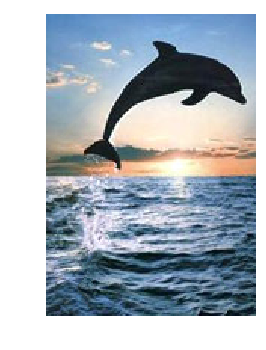

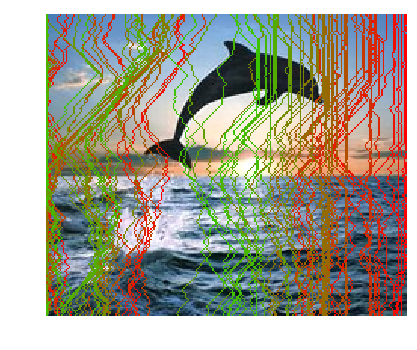

In [19]:
dolphin_fig = cv.imread('images/fig8.png')
#dolphin_fig= cv.GaussianBlur(dolphin_fig, (3, 3), 0, 0, cv.BORDER_DEFAULT)
carve_seams(dolphin_fig)
image_with_seams = draw_seams(dolphin_fig)
cv.imwrite("image_with_seams_old.png",image_with_seams)

In [20]:
#dolphin_fig = cv.imread('images/fig8.png')
#blur = carve_seams(dolphin_fig)
#draw_seams(blur)

In [21]:
#print(big_dolphin.dtype)

In [22]:
#display_image(get_sobel(cv.cvtColor(dolphin_fig,cv.COLOR_BGR2GRAY)))